# DKTC Test

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

import sentencepiece as spm
from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import TextClassificationPipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# 한글 깨짐 방지

import platform

os = platform.system()

# Windows
if os == 'Windows':
    plt.rc('font', family= 'Malgun Gothic')

# Mac
elif os == 'Darwin':
    plt.rc('font', family= 'AppleGothic')

# Linux
elif os == 'Linux':
    plt.rc('font', family= 'NanumGothic')

else:
    print(f'{os} is not set')

### 데이터 로드 및 전처리
1. 형태소 분석기
2. 불용어 리스트
3. 구두점 처리

In [3]:
train_data_path ="/aiffel/aiffel/aiffel_dlthon_c2/data/new_train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
train_data['conversation'].head(5)

0    지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
Name: conversation, dtype: object

In [5]:
len(train_data)

12092

In [35]:
!pip install konlpy # 형태소 분석
!pip install packages

     |████████████████████████████████| 72 kB 770 kB/s             
     |████████████████████████████████| 515 kB 14.6 MB/s            
     |████████████████████████████████| 82 kB 1.6 MB/s             
  Attempting uninstall: redis
    Found existing installation: redis 4.0.2
    Uninstalling redis-4.0.2:
      Successfully uninstalled redis-4.0.2
  Attempting uninstall: click
    Found existing installation: click 8.0.3
    Uninstalling click-8.0.3:
      Successfully uninstalled click-8.0.3


In [6]:
from konlpy.tag import Okt

# 형태소 분석기와 불용어 목록 정의
okt = Okt()

# 불용어 리스트 정의 (필요에 따라 확장 가능)
stopwords = ["이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"]

# 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.lower()     # 1. 소문자 변환 (한국어에는 큰 영향을 미치지 않지만 영문 대비용)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    # 2. 구두점 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)    # 3. 중복된 공백 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]+", " ", sentence)    # 4. 한글과 구두점 이외의 문자 제거
    sentence = re.sub(r"\s+", " ", sentence)
    
    tokens = okt.morphs(sentence, stem=True)     # 5. 형태소 분석-어간추출

    tokens = [word for word in tokens if word not in stopwords]    # 6. 불용어 제거

    sentence = " ".join(tokens)    # 7. 최종 문장 생성
    sentence = sentence.strip()    # 8. 좌우 공백 제거

    return sentence

# 전처리 적용
train_data['conversation'] = train_data['conversation'].apply(preprocess_sentence)


# 전처리된 데이터 확인
print(train_data.head())

   idx      class                                       conversation
0    0      협박 대화  지금 너 스스로 죽이다 달라 고 애원 하다 것 인가 ? 아니다 . 죄송하다 . 죽 ...
1    1      협박 대화  길동 경찰서 이다 . 9시 40분 마트 폭발물 설치 하다 . 네 ? 똑바로 들다 한...
2    2  기타 괴롭힘 대화  너 되게 귀엽다 알 지 ? 나 보다 작다 남자 는 첨 보다 . 그만하다 . 니 놀리...
3    3      갈취 대화  어이 거기 예 ? ? 너 말 이야 너 . 이리 오라 고 무슨 일 . 너 옷 좋다 보...
4    4      갈취 대화  저기 요 혹시 날 너무 뜨겁다 ? 저희 회사 에서 선크림 팔다 하다 번 손등 발라 ...


In [7]:
train_data['conversation'].head(5)

0    지금 너 스스로 죽이다 달라 고 애원 하다 것 인가 ? 아니다 . 죄송하다 . 죽 ...
1    길동 경찰서 이다 . 9시 40분 마트 폭발물 설치 하다 . 네 ? 똑바로 들다 한...
2    너 되게 귀엽다 알 지 ? 나 보다 작다 남자 는 첨 보다 . 그만하다 . 니 놀리...
3    어이 거기 예 ? ? 너 말 이야 너 . 이리 오라 고 무슨 일 . 너 옷 좋다 보...
4    저기 요 혹시 날 너무 뜨겁다 ? 저희 회사 에서 선크림 팔다 하다 번 손등 발라 ...
Name: conversation, dtype: object

### 데이터프레임 인덱싱
1. conversation 컬럼이 결측치인지 확인
2. 결측치인 데이터만 뽑아내기
3. 결측치인 데이터의 개수를 세기

In [8]:
null_check = pd.isnull(train_data['conversation'])
print(null_check)

0        False
1        False
2        False
3        False
4        False
         ...  
12087    False
12088    False
12089    False
12090    False
12091    False
Name: conversation, Length: 12092, dtype: bool


In [9]:
null_data = train_data.loc[null_check, 'conversation']
null_data.head()

Series([], Name: conversation, dtype: object)

In [10]:
print(f'id: {len(null_data.values)}')

id: 0


In [11]:
for c in train_data.columns:
    print('{} : {}'.format(c, len(train_data.loc[pd.isnull(train_data[c]), c].values)))

idx : 0
class : 0
conversation : 0


## 데이터 그래프 시각화
class당 각 대화의 개수와 길이를 확인해보자

### 대화 개수 히스토그램
Class별 Conversation 개수 확인

결과: 확실히 일반 컬럼의 데이터 개수가 가장 많은 것으로 볼 수 있다.
다른 클래스들은 1000개 정도 까지 분포되어 있다는 것을 확인

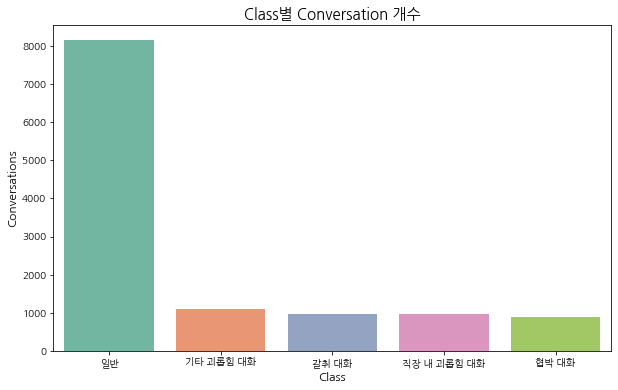

In [8]:
class_counts = train_data['class'].value_counts().reset_index()
class_counts.columns = ['class', 'count']  # 컬럼 이름 설정

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='class', y='count', data=class_counts, palette='Set2')

plt.title('Class별 Conversation 개수', fontsize=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Conversations', fontsize=12)
plt.show()

### 대화 길이 분포 히스토그램
현재 class당 텍스트의 길이를 측정

결과: 다른 클래스 보다 일반 클래스의 대화 길이가 가장 평균적으로 낮았다.

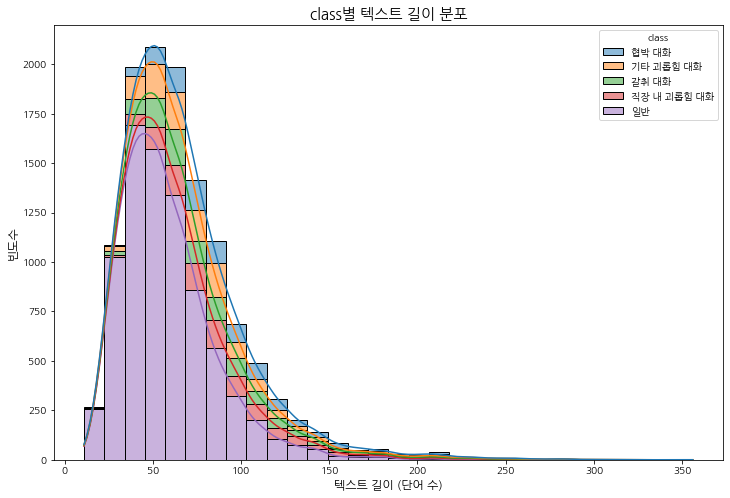

In [22]:
train_data['text_length'] = train_data['conversation'].apply(lambda x: len(x.split()))

# 카테고리별 텍스트 길이 분포를 시각화하는 히스토그램
plt.figure(figsize=(12, 8))
sns.histplot(data=train_data, x='text_length', hue='class', multiple="stack", bins=30, kde=True)
plt.title('class별 텍스트 길이 분포', fontsize=15)
plt.xlabel('텍스트 길이 (단어 수)', fontsize=12)
plt.ylabel('빈도수', fontsize=12)
plt.show()


## 업샘플링
데이터의 불균형을 초래할 수 있기에 다른 클래스의 데이터 분포와 같이 조정

In [10]:
number_min_label = min(group_count)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 896


In [14]:
train_data = train_data.groupby("class").sample(number_min_label, random_state = 200)
train_data.groupby("class").count().iloc[:,0]

class
갈취 대화          896
기타 괴롭힘 대화      896
일반             896
직장 내 괴롭힘 대화    896
협박 대화          896
Name: idx, dtype: int64

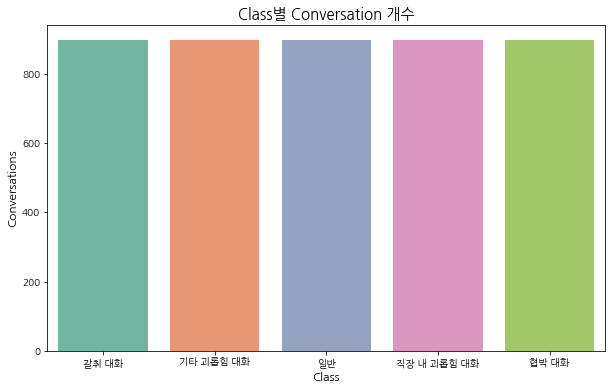

In [15]:
# 히스토그램 그래프로 다시 확인

class_counts = train_data['class'].value_counts().reset_index()
class_counts.columns = ['class', 'count']  # 컬럼 이름 설정

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='class', y='count', data=class_counts, palette='Set2')

plt.title('Class별 Conversation 개수', fontsize=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Conversations', fontsize=12)
plt.show()

대화의 최소 길이 : 13
대화의 최대 길이 : 356
대화의 평균 길이 : 79.79486607142857


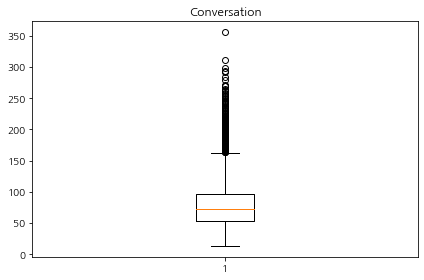

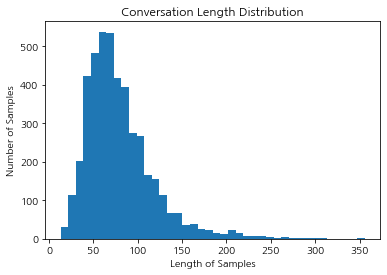

In [29]:
# 길이 분포 출력
conversation_len = [len(s.split()) for s in train_data['conversation']]
class_label_len = [len(s.split()) for s in train_data['class']]

print('대화의 최소 길이 : {}'.format(np.min(conversation_len)))
print('대화의 최대 길이 : {}'.format(np.max(conversation_len)))
print('대화의 평균 길이 : {}'.format(np.mean(conversation_len)))

# 길이 분포 시각화
plt.subplot(1, 1, 1)
plt.boxplot(conversation_len)
plt.title('Conversation')

plt.tight_layout()
plt.show()

plt.title('Conversation Length Distribution')
plt.hist(conversation_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [30]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 120
print(MAX_LENGTH)

120


## 훈련셋 검증셋 데이터 나누기

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 'class'에 있는 '일반 대화' 클래스가 있는지 확인하는 함수
def filter_general_class(df, class_column='class', general_class='일반'):
    return df[df[class_column] == general_class]

# '일반 대화' 클래스가 아닌 데이터를 필터링하는 함수
def filter_non_general_class(df, class_column='class', general_class='일반'):
    return df[df[class_column] != general_class]

# 데이터 X, Y 정의 (conversation -> X, class -> Y)
X = train_data['conversation'].tolist()
Y = train_data['class'].astype('category').cat.codes.tolist()  # class를 숫자형으로 변환

# 일반 대화가 없는 train 데이터와 있는 test 데이터로 분리
train_data_non_general = filter_non_general_class(train_data)
test_data_general = filter_general_class(train_data)

# Train, Val/Test Split (일반 대화가 없는 데이터를 train 데이터로 사용)
X_train, X_val_test, y_train, y_val_test = train_test_split(
    train_data_non_general['conversation'].tolist(),
    train_data_non_general['class'].astype('category').cat.codes.tolist(),
    test_size=0.1,
    random_state=200,
    stratify=train_data_non_general['class'].astype('category').cat.codes.tolist()
)

# Val/Test 데이터 나누기
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=0.5,
    random_state=202,
    stratify=y_val_test
)

# Test 데이터셋에는 일반 대화만 포함 (class 제외)
test_data = test_data_general[['id', 'conversation']].copy()

# Train 데이터셋에는 일반 대화가 없는 데이터만 포함
train_data = pd.DataFrame({'id': train_data_non_general['id'], 'class': y_train, 'conversation': X_train})

# 결과 확인
print(f"Train 데이터 (일반 대화 제외): {train_data.shape}")
print(f"Test 데이터 (일반 대화 포함): {test_data.shape}")
print(f"검증 데이터: {len(X_val)}")
print(f"테스트 데이터: {len(X_test)}")


KeyError: "['id'] not in index"

## koGPT 모델, 토크나이저

In [21]:
!pip install torch

In [31]:
print(train_dataset.element_spec)


({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [23]:
import torch
# GPU 설정 (가능할 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# koGPT 모델과 토크나이저 불러오기
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [27]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training

class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        item = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        # 라벨이 있는 경우, 정수형 라벨을 사용하도록 수정 (수정된 부분)
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # 라벨은 정수형으로 변환됨

        return item

In [32]:
# 훈련 및 테스트 데이터 준비 
train_texts = train_data['conversation'].tolist()
train_labels = train_data['class'].tolist()

test_texts = test['text'].tolist()  # 라벨 없이 텍스트만 사용
# test_labels는 테스트 데이터에 없으므로 None으로 설정

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

TypeError: list indices must be integers or slices, not str

## HuggingFace torch 적용

In [39]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

In [40]:
set_seed(123)
epochs = 1
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path='skt/kogpt2-base-v2'
labels_ids = {'협박 대화':0, '갈취 대화':1,'직장 내 괴롭힘 대화':2,
              '기타 괴롭힘 대화':3,'일반 대화':4}
n_labels = len(labels_ids)
n_labels

5

In [41]:
label_names

['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

In [48]:
from transformers import AutoTokenizer

# koGPT2 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")

# pad_token 설정
tokenizer.pad_token = tokenizer.eos_token

# 데이터를 koGPT 모델에 맞게 토큰화하는 함수 정의
def tokenize_function(text_list):
    return tokenizer(text_list, padding="max_length", truncation=True, return_tensors="pt", max_length=128)

# 학습, 검증, 테스트 데이터를 토큰화
train_encodings = tokenize_function(x_train)
val_encodings = tokenize_function(x_val)
test_encodings = tokenize_function(x_test)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [49]:
import torch
from torch.utils.data import Dataset

# 토큰화된 데이터를 Dataset 클래스로 정의
class ConversationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Hugging Face Dataset 생성
train_dataset = ConversationDataset(train_encodings, y_train)
val_dataset = ConversationDataset(val_encodings, y_val)
test_dataset = ConversationDataset(test_encodings, y_test)


In [51]:
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

# koGPT 모델 및 토크나이저 불러오기
model_name = "skt/kogpt2-base-v2"
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# pad_token 추가 (필요한 경우)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

# 텐서 타입 확인 및 변환 (str 타입을 숫자로 변환하는 과정이 필요할 수 있음)
import torch

def prepare_input(text):
    tokens = tokenizer.encode(text, return_tensors="pt")  # 텐서 형식으로 변환
    return tokens

# 예시 텍스트
text = "안녕하세요, GPT 모델을 사용해봅니다."

# 텍스트 인코딩 및 입력 준비
input_tokens = prepare_input(text)

# 모델에 입력 후 결과 확인
outputs = model(input_tokens)


loading file https://huggingface.co/skt/kogpt2-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/skt/kogpt2-base-v2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/skt/kogpt2-base-v2/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/skt/kogpt2-base-v2/resolve/main/tokenizer.json from cache at /aiffel/.cache/huggingface/transformers/fd8418e6675550cbca8ad6c102d717aa89372eb7a632ad3168300c7fed43491c.db074bfdd88bec54455de5ee2400efdbc64d4acf449a44d5f314e79c1eadc611
loading configuration file https://huggingface.co/skt/kogpt2-base-v2/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/13bb826cf24517d7849a701e02452715a67c5e560142be3d4735442b2a545809.6b384eec6effdd44287f67715cd55bd0dff2cf846d843b932b43ba7b632b8b1e
Model config GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],

In [53]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 입력 텍스트를 모델에 입력하여 예측값 생성
def predict(text):
    input_ids = tokenizer.encode(text, return_tensors='pt')  # 텍스트를 텐서로 변환
    outputs = model.generate(input_ids)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)  # 예측 결과를 디코딩
    return prediction


In [54]:
# 테스트 데이터에 대한 예측
y_pred = [predict(text) for text in x_test]  # 테스트 셋에 대한 예측

# 성능 평가 (정확도, F1 스코어, 정밀도, 재현율)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 클래스가 여러 개일 경우 'weighted' 사용
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


Input length of input_ids is 64, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 307, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 78, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 115, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 192, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Input length of input_ids is 126, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should conside

Accuracy: 0.0000
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
import tensorflow as tf

# 데이터셋을 TensorFlow의 Dataset 형태로 변환
def encode_texts(texts, tokenizer, max_length):
    input_ids = []
    for text in texts:
        encodings = tokenizer.encode_plus(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="tf"
        )
        input_ids.append(encodings['input_ids'])
    return tf.convert_to_tensor(input_ids)

# 학습 데이터셋 준비
train_dataset = tf.data.Dataset.from_tensor_slices((encode_texts(x_train, tokenizer, max_length=64), tf.convert_to_tensor(y_train)))
train_dataset = train_dataset.shuffle(1000).batch(16)

# 검증 데이터셋 준비
val_dataset = tf.data.Dataset.from_tensor_slices((encode_texts(x_val, tokenizer, max_length=64), tf.convert_to_tensor(y_val)))
val_dataset = val_dataset.batch(16)


In [59]:
from transformers import TFAutoModelForCausalLM, AutoTokenizer
import tensorflow as tf

# 모델과 토크나이저 로드
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 패딩 토큰 설정 (eos_token을 pad_token으로 설정)
tokenizer.pad_token = tokenizer.eos_token

# GPT 모델 로드, from_pt=True로 PyTorch 모델을 TensorFlow로 변환
model = TFAutoModelForCausalLM.from_pretrained(model_name, from_pt=True)

# 옵티마이저와 손실 함수 정의
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 모델을 컴파일
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# 데이터셋 전처리 함수
def encode_texts(texts, tokenizer, max_length):
    input_ids = []
    for text in texts:
        # 텍스트를 정수 인코딩하고 패딩 적용
        encodings = tokenizer.encode_plus(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="tf"
        )
        input_ids.append(encodings['input_ids'])
    return tf.convert_to_tensor(input_ids)

# 데이터셋 준비
x_train_encoded = encode_texts(x_train, tokenizer, max_length=64)
x_val_encoded = encode_texts(x_val, tokenizer, max_length=64)

# 라벨을 텐서로 변환
y_train_tensor = tf.convert_to_tensor(y_train)
y_val_tensor = tf.convert_to_tensor(y_val)

# 데이터셋 만들기
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_encoded, y_train_tensor))
train_dataset = train_dataset.shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_encoded, y_val_tensor))
val_dataset = val_dataset.batch(16)

# 모델 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/skt/kogpt2-base-v2/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/13bb826cf24517d7849a701e02452715a67c5e560142be3d4735442b2a545809.6b384eec6effdd44287f67715cd55bd0dff2cf846d843b932b43ba7b632b8b1e
Model config GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
  "created_date": "2021-04-28",
  "embd_pdrop": 0.1,
  "eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "license": "CC-BY-NC-SA 4.0",
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1

Epoch 1/3


UnimplementedError: 2 root error(s) found.
  (0) Unimplemented:  Cast string to float is not supported
	 [[node sparse_categorical_crossentropy/Cast (defined at opt/conda/lib/python3.9/site-packages/transformers/modeling_tf_utils.py:769) ]]
  (1) Cancelled:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_86877]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/Cast:
 ExpandDims (defined at opt/conda/lib/python3.9/site-packages/transformers/modeling_tf_utils.py:760)

Function call stack:
train_function -> train_function


In [21]:
# Tokenizing
train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

for key in train_encodings:
  print(f"{key} : {train_encodings[key][0]}")

input_ids : [2, 4370, 647, 2328, 4267, 1047, 2062, 35, 752, 1047, 2062, 1545, 4200, 3934, 3761, 2062, 7562, 1563, 35, 3660, 4200, 732, 1438, 1513, 2062, 1381, 1583, 1545, 4200, 1460, 4370, 1513, 2062, 3994, 4061, 1396, 850, 5489, 13431, 4209, 2062, 23650, 2205, 2062, 4200, 4209, 2062, 3660, 5261, 11260, 850, 1415, 2062, 4940, 4200, 1556, 1378, 12975, 2062, 1897, 1564, 2062, 5489, 1478, 2178, 809, 4200, 831, 6045, 2205, 2062, 1380, 2062, 35, 8718, 4209, 2062, 1889, 2062, 5843, 4940, 4200, 4040, 2205, 2062, 4243, 1556, 882, 2062, 1564, 2062, 4828, 4209, 2062, 3715, 2062, 10864, 859, 2062, 752, 1381, 2062, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [37]:
!pip install transformers datasets

In [22]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings),
                                                  y_val))
train_dataset

<TensorSliceDataset shapes: ({input_ids: (441,), token_type_ids: (441,), attention_mask: (441,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.string)>

In [33]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩을 사용하여 '일반', '특별' 같은 클래스 값을 숫자로 변환
label_encoder = LabelEncoder()
train_data['class'] = label_encoder.fit_transform(train_data['class'])

# 변환된 클래스 값 확인
print(train_data['class'].unique())
num_labels = max(train_data["class"]) + 1
model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH,
                                                        num_labels=num_labels,
                                                        from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer,
              loss=model.compute_loss,
              metrics=['accuracy'])
model.summary()

[2 4 1 0 3]


Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  110617344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 110,621,189
Trainable params: 110,621,189
Non-trainable params: 0
_________________________________________________________________


In [39]:
# train_dataset의 구조를 확인
for batch in train_dataset.take(1):
    print(batch)


({'input_ids': <tf.Tensor: shape=(441,), dtype=int32, numpy=
array([    2,  4370,   647,  2328,  4267,  1047,  2062,    35,   752,
        1047,  2062,  1545,  4200,  3934,  3761,  2062,  7562,  1563,
          35,  3660,  4200,   732,  1438,  1513,  2062,  1381,  1583,
        1545,  4200,  1460,  4370,  1513,  2062,  3994,  4061,  1396,
         850,  5489, 13431,  4209,  2062, 23650,  2205,  2062,  4200,
        4209,  2062,  3660,  5261, 11260,   850,  1415,  2062,  4940,
        4200,  1556,  1378, 12975,  2062,  1897,  1564,  2062,  5489,
        1478,  2178,   809,  4200,   831,  6045,  2205,  2062,  1380,
        2062,    35,  8718,  4209,  2062,  1889,  2062,  5843,  4940,
        4200,  4040,  2205,  2062,  4243,  1556,   882,  2062,  1564,
        2062,  4828,  4209,  2062,  3715,  2062, 10864,   859,  2062,
         752,  1381,  2062,    18,     3,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  

In [49]:
def convert_tensor_to_numpy(dataset):
    inputs, labels = [], []
    for example in dataset:
        # 튜플로 접근해야 한다면, 예시가 (inputs, labels) 형식이라고 가정
        input_tensor = example[0]  # 튜플에서 첫 번째 요소는 입력
        label_tensor = example[1]  # 튜플에서 두 번째 요소는 라벨
        
        inputs.append(input_tensor())  # 넘파이로 변환
        labels.append(label_tensor())  # 넘파이로 변환
    return inputs, labels

# train_dataset과 val_dataset의 라벨을 추출하고 텐서를 넘파이로 변환
train_inputs, train_labels = convert_tensor_to_numpy(train_dataset)
val_inputs, val_labels = convert_tensor_to_numpy(val_dataset)

# 문자열 라벨을 정수로 변환
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)

# 다시 데이터셋으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, encoded_train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, encoded_val_labels))

# 모델 학습
callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,  # 최소 개선율
    patience=2)

model.fit(
    train_dataset.shuffle(1000).batch(16), 
    epochs=1, 
    batch_size=16,
    validation_data=val_dataset.shuffle(1000).batch(16),
    callbacks=[callback_earlystop]
)


TypeError: 'dict' object is not callable